# Effects of User Characteristics and Usage Situations on Trip Duration
## by Hiroyuki Kondo

## Investigation Overview

Baywheels is a bike share service by Lyft in the Bay Area. In this investigation, I want to figure out what characteristics of users and situations influence the trip durations of users of baywheels. I mainly focus on the day of a week, time of day, and user types.

## Dataset Overview

There are 239,895 trip data in this dataset, including trip information and user characteristics: the trip duration, start and end time, user type, birth year, and gender. I downloaded them from the baywheels website (https://s3.amazonaws.com/baywheels-data/index.html). 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
#warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
baywheels = pd.read_csv("data/201910-baywheels-tripdata.csv")

In [3]:
# Make some columns
baywheels["start_time_dt"] = pd.to_datetime(baywheels['start_time'])
baywheels["end_time_dt"] = pd.to_datetime(baywheels['end_time'])
baywheels["member_birth_year"] = baywheels["member_birth_year"].fillna(0).astype(int)
baywheels["start_wdn"] = baywheels["start_time_dt"].dt.weekday_name
baywheels["start_hour"] = baywheels["start_time_dt"].dt.hour
baywheels["start_date"] = baywheels["start_time_dt"].dt.day
baywheels["age"] = 2019 - baywheels["member_birth_year"]
baywheels["age_group"] = baywheels["age"]//10 * 10
baywheels["weekdays_fl"] = baywheels["start_wdn"].isin(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]) 
baywheels.loc[baywheels['weekdays_fl'], 'weekdays'] = "Weekday"
baywheels.loc[~(baywheels['weekdays_fl']), 'weekdays'] = "Weekend"
baywheels["log_duration_sec"] = np.log10(baywheels["duration_sec"])

## Distribution of Trip Duration

The trip duration in this dataset takes on a wide range of values. The shortest trip is about 60 seconds, and the longest one is more than 23 hours. When plotted on a log-scale, the distribution looks unimodal and symmetrical.

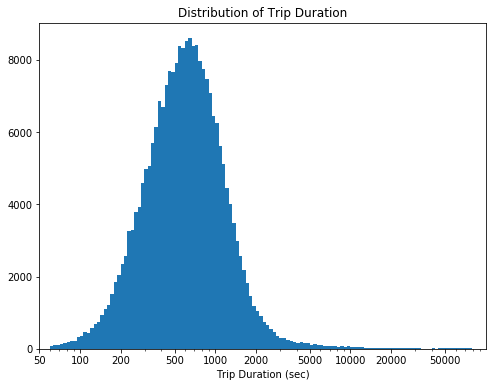

In [4]:
log_binsize = 0.025
bins = 10 ** np.arange(1,  np.log10(baywheels["duration_sec"].max())+log_binsize, log_binsize)

plt.figure(figsize = (8,6))
plt.hist(data = baywheels, x ="duration_sec", bins = bins);
plt.xscale("log")
xticks = [50, 100, 200, 500, 1e3, 2e3, 5e3, 1e4, 2e4, 5e4]
xlabels = ["{:.0f}".format(v) for v in xticks]
plt.xlim(50, 1e5)
plt.xticks(xticks, xlabels)
plt.title("Distribution of Trip Duration")
plt.xlabel("Trip Duration (sec)");

## Number of trips on Each Day of a Week

The result shows that the number of rides on weekdays is more than 8000 and is larger than those on the weekend.

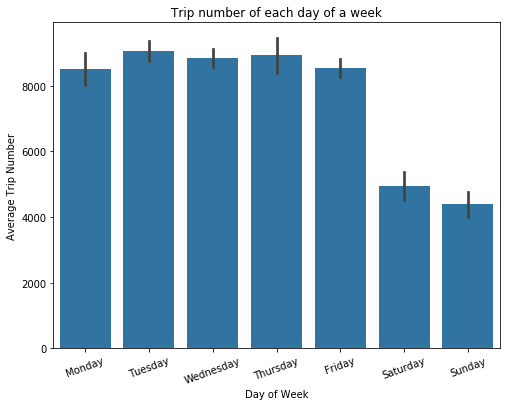

In [5]:
plt.figure(figsize = (8,6))
day_classes = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

dclasses = pd.api.types.CategoricalDtype(ordered = True, categories = day_classes)
baywheels["start_wdn"] = baywheels["start_wdn"].astype(dclasses)

trip_num_day = baywheels.groupby("start_date").size().reset_index()
day_name = baywheels.groupby("start_date").first()["start_wdn"].reset_index()
baywheels_sub = pd.merge(trip_num_day, day_name, on = "start_date").rename(columns = {0: "trip_num"})

base_color = sb.color_palette()[0]

sb.barplot(data = baywheels_sub, x = "start_wdn", y = "trip_num", ci = "sd", color = base_color, order = day_classes)
plt.title("Trip number of each day of a week")
plt.xlabel("Day of Week");
plt.xticks(rotation = 20);
plt.ylabel("Average Trip Number");

## Trip Duration of Each Day of a Week

The violin plots indicate that the medians of the trip duration on weekdays are about 590 seconds, and those on weekends are around 660 seconds. People ride a bicycle for a longer time on Saturdays and Sundays than on weekdays.

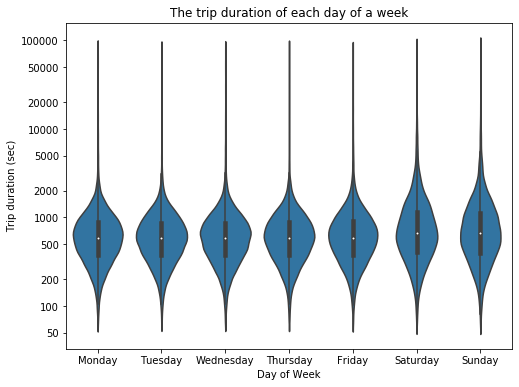

In [6]:
day_classes = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize = (8,6))
base_color = sb.color_palette()[0]
sb.violinplot(data = baywheels, x = "start_wdn", y = "log_duration_sec", order = day_classes, color = base_color)

yticks = np.log10(np.array([50, 100, 200, 500, 1e3, 2e3, 5e3, 1e4, 2e4, 5e4, 1e5]))
ylabels = ["50", "100", "200", "500", "1000", "2000", "5000", "10000", "20000", "50000", "100000"]
plt.yticks(yticks, ylabels)

plt.title("The trip duration of each day of a week")
plt.xlabel("Day of Week");
plt.ylabel("Trip duration (sec)");

## Comparison of Trip Duration of Two Different User Types

There are two types of users in this dataset: subscribers and customers, people who pay the fee every time they use it. The median of trip durations by subscribers is 550 seconds, which is 250 seconds shorter than customers. In general, the customers tend to rent a bike longer than subscribers.

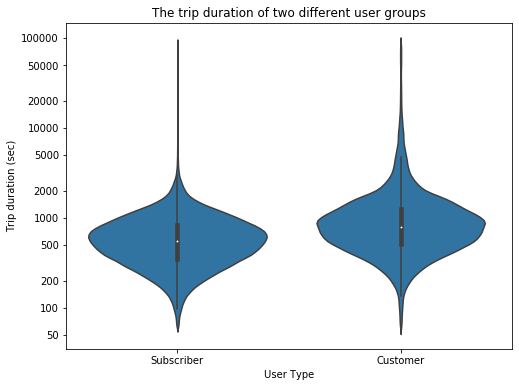

In [7]:
plt.figure(figsize = (8,6))
base_color = sb.color_palette()[0]
sb.violinplot(data = baywheels, x = "user_type", y = "log_duration_sec", color = base_color, order = ["Subscriber", "Customer"])

yticks = np.log10(np.array([50, 100, 200, 500, 1e3, 2e3, 5e3, 1e4, 2e4, 5e4, 1e5]))
ylabels = ["50", "100", "200", "500", "1000", "2000", "5000", "10000", "20000", "50000", "100000"]
plt.yticks(yticks, ylabels)

plt.title("The trip duration of two different user groups")
plt.xlabel("User Type");
plt.ylabel("Trip duration (sec)");

## Trip Duration by Start Time and User Type for Weekdays and Weekends

We can see how user types and start time affect the trip duration by plotting the average period on weekdays and weekends. Both of these two charts show that customers ride a bicycle for a longer time than subscribers at any time of the day. Especially, the trip duration of customers around 2 p.m. on weekends are about 2000 seconds, which is twice as long as subscribers. Surprisingly, the average trip duration of customers at night is more than 2000 seconds. However, the confidence intervals are really large. It is expected that some outliers affect the average.

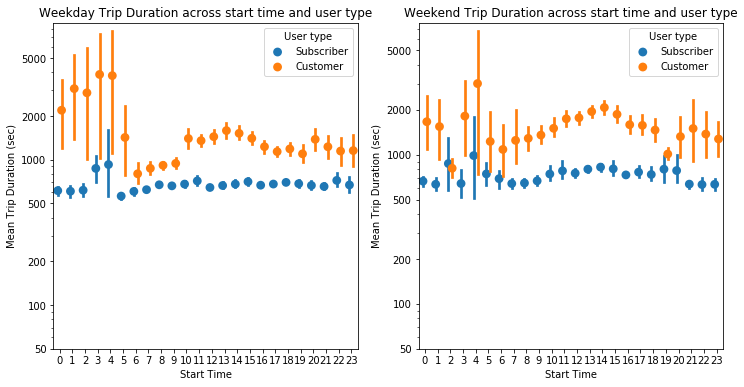

In [8]:
fig, ax = plt.subplots(ncols = 2, figsize = [12,6])

sb.pointplot(data = baywheels.query("weekdays == 'Weekday'"),  x = "start_hour", y = "duration_sec",
             hue = "user_type",  hue_order = ["Subscriber", "Customer"], linestyles = '', dodge = 0.3, ax = ax[0]);
ax[0].set_title('Weekday Trip Duration across start time and user type')
ax[0].set_xlabel('Start Time')
ax[0].set_ylabel('Mean Trip Duration (sec)')
ax[0].legend(title='User type')
ax[0].set_yscale('log')
ax[0].set_yticks([50, 100, 200, 500, 1000, 2000, 5000])
ax[0].set_yticklabels(["50", "100", "200", "500", "1000", "2000", "5000"])
ax[0].set_yticklabels([],minor = True)

sb.pointplot(data = baywheels.query("weekdays == 'Weekend'"), x = "start_hour", y = "duration_sec", 
             hue = "user_type",  hue_order = ["Subscriber", "Customer"], linestyles = '', dodge = 0.3, ax = ax[1]);
ax[1].set_title('Weekend Trip Duration across start time and user type')
ax[1].set_xlabel('Start Time')
ax[1].set_ylabel('Mean Trip Duration (sec)')
ax[1].legend(title='User type')
ax[1].set_yscale('log')
ax[1].set_yticks([50, 100, 200, 500, 1000, 2000, 5000])
ax[1].set_yticklabels(["50", "100", "200", "500", "1000", "2000", "5000"])
ax[1].set_yticklabels([],minor = True)
plt.show();